In [ ]:
import scipy.io.wavfile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
from scipy.spatial.distance import hamming
from fastdtw import fastdtw
import librosa
import librosa.display
%matplotlib inline

In [4]:
def trim(sig, fs, startTime, endTime):
    startTimeIdx = round((startTime[0] * 60 + startTime[1]) * fs)
    endTimeIdx   = round((endTime[0] * 60 + endTime[1]) * fs)
    
    print("signal shape = {:} frame rate = {:}".format(sig.shape, fs), file=sys.stderr)
    print("startTimeIdx = {:} endTimeIdx = {:}".format(startTimeIdx, endTimeIdx), file=sys.stderr)
    
    return sig[startTimeIdx:endTimeIdx], fs

In [5]:
def generateChunks(sig, fs, chunkLengthSec, verbose=False):
    chunkLengthSize = round(chunkLengthSec * fs)
    
    chunkIdx = 0
    currentEnding = 0
    output = []
    while currentEnding + chunkLengthSize < sig.shape[0]:
        output.append(sig[currentEnding:currentEnding + chunkLengthSize])
        if(verbose): print("[{:3d}] idx = [{:7d},{:7d})".format(chunkIdx, currentEnding, currentEnding + chunkLengthSize), file=sys.stderr)
        chunkIdx += 1
        currentEnding += chunkLengthSize
    
    if(verbose): print("[{:3d}] idx = [{:7d},{:7d})".format(chunkIdx, currentEnding, sig.shape[0]), file=sys.stderr)
    output.append(sig[currentEnding: sig.shape[0]])
    return output

In [7]:
# Load the concert track
filename = "Taylor_Swift_-_22_STB_2013_.wav"
concertTrack, fs = librosa.load(filename)
startTime = (0,24) # (minute, second)
endTime   = (4,16) # (minute, second)
concertTrack, fs = trim(concertTrack, fs, startTime, endTime)
concertChunks = generateChunks(concertTrack, fs, 6.0)

signal shape = (6218384,) frame rate = 22050
startTimeIdx = 529200 endTimeIdx = 5644800


In [8]:
# Define a hop size for computing chroma features
hop_size=512

In [11]:
# Obtain chroma features for the album track
filename = "Taylor_Swift_-_22.wav"
albumTrack, fs = librosa.load(filename)
X_2_chroma = librosa.feature.chroma_cqt(y=albumTrack, sr=fs,
                                        hop_length=hop_size, # number of samples between consecutive frames
                                        n_chroma=12,    # number of chroma bins to produce
                                        )

/Users/teerapatjenrungrot/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/spatial/distance.py:1833: RuntimeWarning: invalid value encountered in true_divide
  dm /= _row_norms(XB)


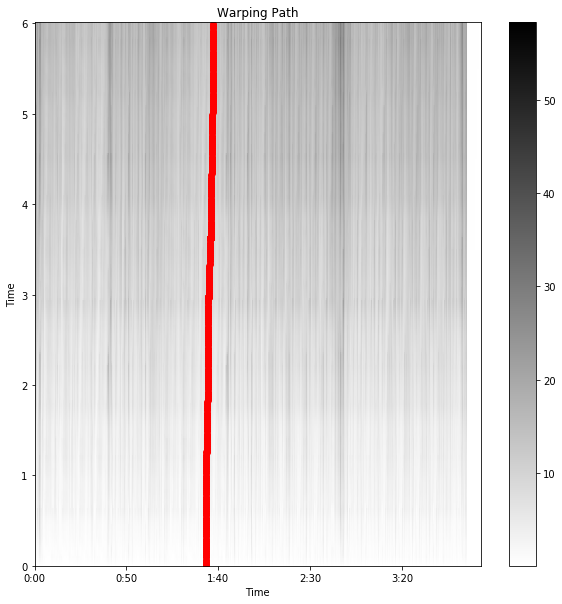

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
    
# for idx in range(len(concertChunks)):
    # Obtain chroma features for each chunk of the concert track
X_1_chroma = librosa.feature.chroma_cqt(y=concertChunks[0], sr=fs,
                                        hop_length=hop_size, # number of samples between consecutive frames
                                        n_chroma=12,    # number of chroma bins to produce
                                        )

# Compute DTW 
D, wp = librosa.core.dtw(X=X_1_chroma, Y=X_2_chroma, metric='cosine', subseq=True)
# Convert
wp_s = np.asarray(wp) * hop_size / fs


librosa.display.specshow(D, x_axis='time', y_axis='time', cmap='gray_r',
                         hop_length=hop_size)
if(idx%2 == 0): ax.plot(wp_s[:,1], wp_s[:,0], marker='o', color='red')
else:           ax.plot(wp_s[:,1], wp_s[:,0], marker='o', color='blue')
    

imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                     origin='lower', interpolation='nearest', aspect='auto') 
plt.title("Warping Path")
plt.colorbar()
plt.show()

In [15]:
X_1_chroma.shape

(12, 259)

In [16]:
X_2_chroma.shape

(12, 10468)